In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

# ==========================================
# 1. CONNEXION ET CHARGEMENT
# ==========================================
print("⏳ Connexion et chargement...")

load_dotenv()

url = URL.create(
    drivername="postgresql+psycopg2",
    username=os.getenv("NEON_USER"),
    password=os.getenv("NEON_PASSWORD"),
    host=os.getenv("NEON_HOST"),
    port=int(os.getenv("NEON_PORT", "5432")),
    database=os.getenv("NEON_DB"),
    query={"sslmode": os.getenv("NEON_SSLMODE", "require")},
)

engine = create_engine(url, pool_pre_ping=True)

print(f"✅ Connecté à la base de données {url.database}.")

fact_env = pd.read_sql("SELECT country_key, year, coal_consumption, gas_consumption, oil_consumption FROM fact_energy_environment;", engine)
fact_soc = pd.read_sql("SELECT country_key, year, gdp FROM fact_socio_economy;", engine)
dim_country = pd.read_sql("SELECT country_key, country_name, iso_code FROM dim_country;", engine)

# Top 10 par GDP en 2020
soc_2020 = fact_soc[(fact_soc["year"] == 2020) & fact_soc["gdp"].notna()]
top10_2020 = soc_2020.nlargest(10, "gdp").merge(dim_country[["country_key", "country_name", "iso_code"]], on="country_key", how="left")
top10_keys = top10_2020["country_key"].tolist()

print(f"🗒️ Top 10 pays: {top10_2020['country_name'].tolist()}")


⏳ Connexion et chargement...
✅ Connecté à la base de données neondb.
🗒️ Top 10 pays: ['China', 'United States', 'India', 'Japan', 'Germany', 'Russia', 'Indonesia', 'Brazil', 'France', 'United Kingdom']


In [2]:
# ==========================================
# 2. PRÉPARATION DES DONNÉES AVEC TAUX DE VARIATION
# ==========================================
print("\n⏳ Préparation des données (taux de variation)...")

def get_country_data(country_key, max_year=2020):
    """Récupère les données d'un pays"""
    df = (
        fact_soc[fact_soc["country_key"] == country_key]
        .merge(
            fact_env[["country_key", "year", "coal_consumption", "gas_consumption", "oil_consumption"]],
            on=["country_key", "year"],
            how="inner",
        )
    )
    df_clean = df[["country_key", "year", "gdp", "coal_consumption", "gas_consumption", "oil_consumption"]].dropna()
    df_clean = df_clean[df_clean["year"] <= max_year].sort_values("year")
    return df_clean

# Construire le dataset
all_data = []
for country_key in top10_keys:
    country_data = get_country_data(country_key)
    all_data.append(country_data)

df_clean = pd.concat(all_data, ignore_index=True)
df_clean = df_clean.merge(dim_country[["country_key", "country_name"]], on="country_key", how="left")

print(f"✅ Données combinées prêtes avec {len(df_clean)} observations, entre {df_clean['year'].min()} et {df_clean['year'].max()}.")



⏳ Préparation des données (taux de variation)...
✅ Données combinées prêtes avec 540 observations, entre 1965 et 2020.


In [3]:
# ==========================================
# CALCULER LES TAUX DE VARIATION (année sur année)
# ==========================================
print("\n⏳ Calcul des taux de variation...")

df_clean = df_clean.sort_values(["country_key", "year"])

# Calculer les variations en % pour chaque pays
df_clean["gdp_growth"] = df_clean.groupby("country_key")["gdp"].pct_change() * 100
df_clean["coal_growth"] = df_clean.groupby("country_key")["coal_consumption"].pct_change() * 100
df_clean["gas_growth"] = df_clean.groupby("country_key")["gas_consumption"].pct_change() * 100
df_clean["oil_growth"] = df_clean.groupby("country_key")["oil_consumption"].pct_change() * 100

# Supprimer les NaN (première année de chaque pays)
df_growth = df_clean.dropna(subset=["gdp_growth", "coal_growth", "gas_growth", "oil_growth"])

# Supprimer les valeurs extrêmes (outliers > 50% de variation)
df_growth = df_growth[
    (df_growth["gdp_growth"].abs() < 50) &
    (df_growth["coal_growth"].abs() < 50) &
    (df_growth["gas_growth"].abs() < 50) &
    (df_growth["oil_growth"].abs() < 50)
]

print(f"✅ Observations: {len(df_growth)} | Période: {df_growth['year'].min()}-{df_growth['year'].max()}")

print("\n📊 Statistiques des taux de variation (%):")
display(df_growth[["gdp_growth", "coal_growth", "gas_growth", "oil_growth"]].describe().round(2))



⏳ Calcul des taux de variation...
✅ Observations: 512 | Période: 1966-2020

📊 Statistiques des taux de variation (%):


,gdp_growth,coal_growth,gas_growth,oil_growth
count,512.00,512.00,512.00,512.00
mean,3.54,1.12,6.20,2.26
std,3.75,9.50,10.72,6.68
min,-12.72,-49.09,-40.86,-21.20
25%,1.54,-3.23,0.34,-1.54
50%,3.30,1.44,4.11,1.66
75%,5.74,5.81,9.94,5.46
max,14.81,37.64,46.43,38.33


In [4]:
# ==========================================
# 3. MODÉLISATION SUR LES TAUX DE VARIATION
# ==========================================
print("\n⏳ Modélisation...")

features = ["coal_growth", "gas_growth", "oil_growth"]
target = "gdp_growth"

X = df_growth[features]
y = df_growth[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Comparaison de modèles
models = {
    "OLS": LinearRegression(),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "ElasticNet": make_pipeline(StandardScaler(), ElasticNet(alpha=0.4, l1_ratio=1.0, max_iter=5)),
    "Random Forest": RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=10, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Modèle": name, "R²": r2, "RMSE": rmse})
    print(f"   {name}: R²={r2:.4f}, RMSE={rmse:.2f}%")

df_results = pd.DataFrame(results)
best_name = df_results.loc[df_results["R²"].idxmax(), "Modèle"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
r2_final = r2_score(y_test, y_test_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n✅ Meilleur modèle: {best_name} (R²={r2_final:.4f}, RMSE={rmse_final:.2f}%)")



⏳ Modélisation...
   OLS: R²=0.3686, RMSE=2.95%
   Ridge: R²=0.3683, RMSE=2.95%
   ElasticNet: R²=0.3792, RMSE=2.92%
   Random Forest: R²=0.4263, RMSE=2.81%
   Gradient Boosting: R²=0.3103, RMSE=3.08%

✅ Meilleur modèle: Random Forest (R²=0.4263, RMSE=2.81%)



⏳ Création des visualisations...


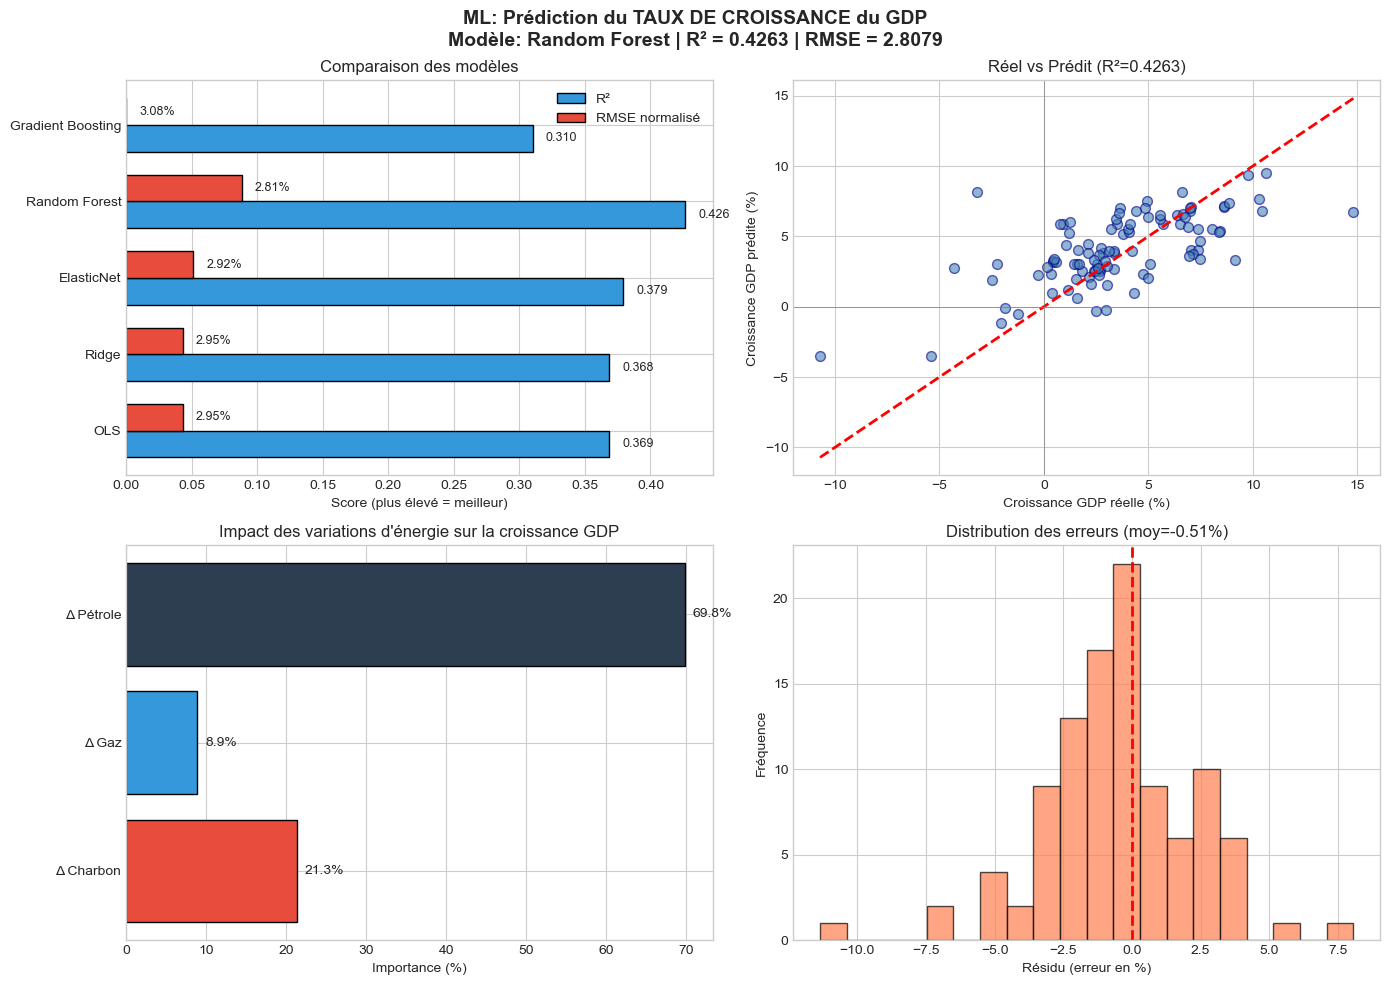

In [5]:
# ==========================================
# 4. VISUALISATIONS DU MODÈLE
# ==========================================
print("\n⏳ Création des visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"ML: Prédiction du TAUX DE CROISSANCE du GDP\nModèle: {best_name} | R² = {r2_final:.4f} | RMSE = {rmse_final:.4f}", fontsize=14, fontweight='bold')

# 4.1 Comparaison modèles (R² et RMSE)
ax = axes[0, 0]
y = np.arange(len(df_results))
height = 0.35

# Normaliser RMSE pour affichage (inverser car plus petit = mieux)
rmse_normalized = 1 - (df_results["RMSE"] / df_results["RMSE"].max())

bars1 = ax.barh(y - height/2, df_results["R²"], height, label='R²', color='#3498db', edgecolor='black')
bars2 = ax.barh(y + height/2, rmse_normalized, height, label='RMSE normalisé', color='#e74c3c', edgecolor='black')

ax.set_xlabel("Score (plus élevé = meilleur)")
ax.set_yticks(y)
ax.set_yticklabels(df_results["Modèle"])
ax.set_title("Comparaison des modèles")
ax.legend(loc='upper right')

# Afficher les valeurs
for bar, r2 in zip(bars1, df_results["R²"]):
    ax.text(max(0, r2) + 0.01, bar.get_y() + bar.get_height()/2, f'{r2:.3f}', va='center', fontsize=9)
for bar, rmse in zip(bars2, df_results["RMSE"]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{rmse:.2f}%', va='center', fontsize=9)

# 4.2 Réel vs Prédit
ax = axes[0, 1]
ax.scatter(y_test, y_test_pred, alpha=0.6, c='steelblue', edgecolors='darkblue', s=50)
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
ax.plot(lims, lims, 'r--', lw=2)
ax.set_xlabel("Croissance GDP réelle (%)")
ax.set_ylabel("Croissance GDP prédite (%)")
ax.set_title(f"Réel vs Prédit (R²={r2_final:.4f})")
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)

# 4.3 Importance des features
ax = axes[1, 0]
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
else:
    for step in ['ridge', 'elasticnet']:
        if step in best_model.named_steps:
            importances = np.abs(best_model.named_steps[step].coef_)
            break
importances = importances / importances.sum() * 100
labels = ['Δ Charbon', 'Δ Gaz', 'Δ Pétrole']
colors_f = ['#e74c3c', '#3498db', '#2c3e50']
bars = ax.barh(labels, importances, color=colors_f, edgecolor='black')
ax.set_xlabel("Importance (%)")
ax.set_title("Impact des variations d'énergie sur la croissance GDP")
for bar, imp in zip(bars, importances):
    ax.text(imp + 1, bar.get_y() + bar.get_height()/2, f'{imp:.1f}%', va='center')

# 4.4 Distribution des résidus
ax = axes[1, 1]
residuals = y_test - y_test_pred
ax.hist(residuals, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', lw=2, ls='--')
ax.set_xlabel("Résidu (erreur en %)")
ax.set_ylabel("Fréquence")
ax.set_title(f"Distribution des erreurs (moy={residuals.mean():.2f}%)")

plt.tight_layout()


In [6]:
# ==========================================
# 5. SCÉNARIOS PROSPECTIFS (2020 → 2025)
# ==========================================
print("\n⏳ Scénarios prospectifs...")

# Données de référence 2020
data_2020 = df_clean[df_clean["year"] == 2020].copy()

# Calculer le mix énergétique de chaque pays en 2020
data_2020["total_fossil"] = data_2020["coal_consumption"] + data_2020["gas_consumption"] + data_2020["oil_consumption"]
data_2020["coal_share"] = data_2020["coal_consumption"] / data_2020["total_fossil"]
data_2020["gas_share"] = data_2020["gas_consumption"] / data_2020["total_fossil"]
data_2020["oil_share"] = data_2020["oil_consumption"] / data_2020["total_fossil"]

print("\n📊 Mix énergétique 2020 (%):")
mix_display = data_2020[["country_name", "coal_share", "gas_share", "oil_share"]].copy()
mix_display[["coal_share", "gas_share", "oil_share"]] = mix_display[["coal_share", "gas_share", "oil_share"]] * 100
print(mix_display.round(1).to_string(index=False))

# Scénarios : taux de réduction annuel des énergies fossiles
scenarios = {
    "Niveau 1 (-2%/an)": {"rate": -2.0, "color": "#f39c12"},
    "Niveau 2 (-3%/an)": {"rate": -3.0, "color": "#e67e22"},
    "Niveau 3 (-4%/an)": {"rate": -4.0, "color": "#e74c3c"}
}

years_pred = [2021, 2022, 2023, 2024, 2025]
results_sc = []

print("\n📊 Élasticités par pays (modèle individuel sur historique 1965-2020):")
print("-" * 70)

for _, row in data_2020.iterrows():
    country = row["country_name"]
    country_key = row["country_key"]
    gdp_2020 = row["gdp"]
    coal_share = row["coal_share"]
    gas_share = row["gas_share"]
    oil_share = row["oil_share"]
    
    # Récupérer l'historique de CE pays uniquement
    country_history = df_growth[df_growth["country_key"] == country_key].copy()
    
    if len(country_history) < 10:
        print(f"   ⚠️ {country}: Pas assez de données ({len(country_history)} obs), utilisation du modèle global")
        country_model = best_model
    else:
        # Entraîner un modèle SPÉCIFIQUE à ce pays
        X_country = country_history[["coal_growth", "gas_growth", "oil_growth"]]
        y_country = country_history["gdp_growth"]
        
        country_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        country_model.fit(X_country, y_country)
        
        # Afficher les stats du modèle par pays
        y_pred_country = country_model.predict(X_country)
        r2_country = r2_score(y_country, y_pred_country)
        print(f"   ✅ {country}: {len(country_history)} obs | R²={r2_country:.3f}")
    
    # Appliquer les scénarios avec le modèle du pays
    for sc_name, params in scenarios.items():
        rate = params["rate"]  # Même taux pour les 3 énergies
        
        # Prédire le taux de croissance GDP avec le modèle du pays
        X_scenario = pd.DataFrame({
            "coal_growth": [rate],
            "gas_growth": [rate],
            "oil_growth": [rate]
        })
        gdp_growth_pred = country_model.predict(X_scenario)[0]
        
        # Ajouter le point de départ 2020 (GDP réel)
        results_sc.append({
            "country": country,
            "scenario": sc_name,
            "year": 2020,
            "gdp_pred": gdp_2020,
            "gdp_2020": gdp_2020,
            "gdp_growth_annual": gdp_growth_pred,
            "change_pct": 0.0,
            "coal_share": coal_share * 100,
            "gas_share": gas_share * 100,
            "oil_share": oil_share * 100,
            "color": params["color"]
        })
        
        # Appliquer cette croissance année après année (2021-2025)
        gdp_current = gdp_2020
        for year in years_pred:
            gdp_current = gdp_current * (1 + gdp_growth_pred / 100)
            change_vs_2020 = ((gdp_current - gdp_2020) / gdp_2020) * 100
            
            results_sc.append({
                "country": country,
                "scenario": sc_name,
                "year": year,
                "gdp_pred": gdp_current,
                "gdp_2020": gdp_2020,
                "gdp_growth_annual": gdp_growth_pred,
                "change_pct": change_vs_2020,
                "coal_share": coal_share * 100,
                "gas_share": gas_share * 100,
                "oil_share": oil_share * 100,
                "color": params["color"]
            })

df_sc = pd.DataFrame(results_sc)

print("\n✅ Modèles par pays entraînés et scénarios calculés.")


⏳ Scénarios prospectifs...

📊 Mix énergétique 2020 (%):
  country_name  coal_share  gas_share  oil_share
        Brazil         9.4       18.1       72.5
         China        67.4        9.7       22.9
        France         4.7       33.9       61.4
       Germany        19.7       33.4       46.9
         India        60.0        7.7       32.3
     Indonesia        40.4       19.9       39.7
         Japan        30.3       24.9       44.8
        Russia        13.1       60.8       26.1
United Kingdom         4.3       50.2       45.5
 United States        12.8       41.9       45.3

📊 Élasticités par pays (modèle individuel sur historique 1965-2020):
----------------------------------------------------------------------
   ✅ Brazil: 53 obs | R²=0.906
   ✅ China: 55 obs | R²=0.793
   ✅ France: 55 obs | R²=0.873
   ✅ Germany: 54 obs | R²=0.780
   ✅ India: 54 obs | R²=0.715
   ✅ Indonesia: 47 obs | R²=0.862
   ✅ Japan: 54 obs | R²=0.900
   ✅ Russia: 35 obs | R²=0.883
   ✅ United Ki

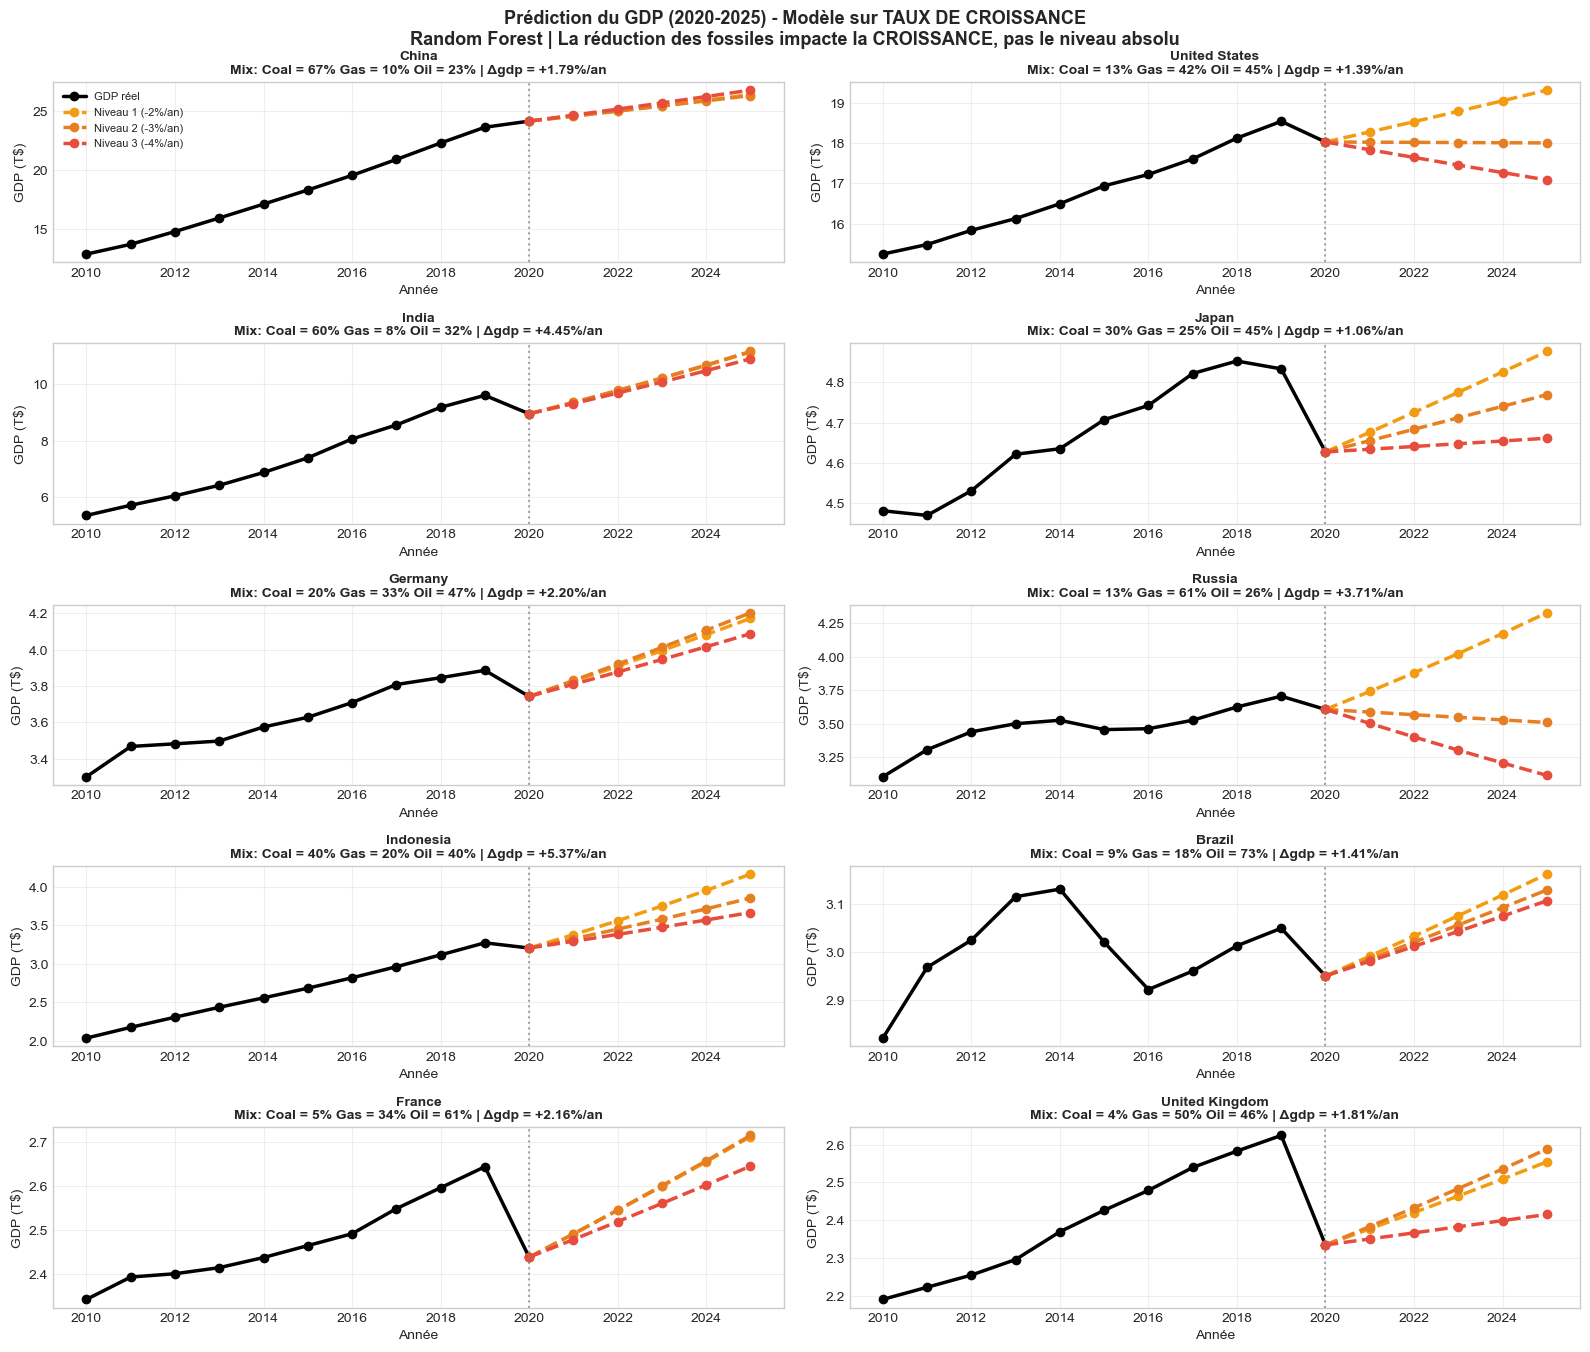

In [7]:
# ==========================================
# 6. VISUALISATION PAR PAYS (2020-2025)
# ==========================================
countries = data_2020.nlargest(10, "gdp")["country_name"].tolist()
n_cols = 2
n_rows = (len(countries) + 1) // 2

fig2, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.75 * n_rows))
axes = axes.flatten()

for i, country in enumerate(countries):
    ax = axes[i]
    country_data = df_sc[df_sc["country"] == country]
    gdp_2020 = country_data["gdp_2020"].iloc[0]
    
    # GDP réel historique (2010-2020)
    hist_data = df_clean[(df_clean["country_name"] == country) & (df_clean["year"] >= 2010)].sort_values("year")
    ax.plot(hist_data["year"], hist_data["gdp"]/1e12, 
            color='black', lw=2.5, marker='o', label='GDP réel')
    
    # Scénarios prédits (2021-2025)
    for sc_name, params in scenarios.items():
        sc_data = country_data[country_data["scenario"] == sc_name].sort_values("year")
        ax.plot(sc_data["year"], sc_data["gdp_pred"]/1e12, 
                color=params["color"], lw=2.5, marker='o', linestyle='--', label=sc_name)
    
    # Récupérer les infos du pays
    growth_n1 = country_data[country_data["scenario"] == "Niveau 1 (-2%/an)"]["gdp_growth_annual"].iloc[0]
    coal_sh = country_data["coal_share"].iloc[0]
    gas_sh = country_data["gas_share"].iloc[0]
    oil_sh = country_data["oil_share"].iloc[0]
    
    ax.set_title(f"{country}\nMix: Coal = {coal_sh:.0f}% Gas = {gas_sh:.0f}% Oil = {oil_sh:.0f}% | Δgdp = {growth_n1:+.2f}%/an", 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel("Année")
    ax.set_ylabel("GDP (T$)")
    ax.axvline(x=2020, color='gray', linestyle=':', alpha=0.7)  # Ligne de séparation réel/prédit
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig2.suptitle(f"Prédiction du GDP (2020-2025) - Modèle sur TAUX DE CROISSANCE\n{best_name} | La réduction des fossiles impacte la CROISSANCE, pas le niveau absolu", 
              fontsize=13, fontweight='bold')
plt.tight_layout()


In [8]:
# ==========================================
# 7. TABLEAU RÉCAPITULATIF
# ==========================================
print("\n📊 Taux de croissance GDP prédit selon le scénario:")
growth_summary = df_sc.groupby("scenario")["gdp_growth_annual"].first().round(2)
print(growth_summary)

print("\n📊 Variation du GDP en 2025 vs 2020 (%):")
df_2025 = df_sc[df_sc["year"] == 2025].pivot_table(
    index="country", 
    columns="scenario", 
    values="change_pct"
).round(2)
df_2025 = df_2025.reindex(countries)
print(df_2025.to_string())



📊 Taux de croissance GDP prédit selon le scénario:
scenario
Niveau 1 (-2%/an)    1.41
Niveau 2 (-3%/an)    1.19
Niveau 3 (-4%/an)    1.04
Name: gdp_growth_annual, dtype: float64

📊 Variation du GDP en 2025 vs 2020 (%):
scenario        Niveau 1 (-2%/an)  Niveau 2 (-3%/an)  Niveau 3 (-4%/an)
country                                                                
China                        9.30               8.98              10.90
United States                7.15              -0.13              -5.24
India                       24.33              24.57              21.67
Japan                        5.41               3.08               0.74
Germany                     11.47              12.30               9.22
Russia                      19.97              -2.70             -13.62
Indonesia                   29.87              20.18              14.35
Brazil                       7.23               6.10               5.33
France                      11.25              11.37        

In [9]:
# ==========================================
# 8. RAPPORT
# ==========================================
print("\n" + "="*60)
print("📋 RAPPORT FINAL - MODÈLE SUR TAUX DE CROISSANCE")
print("="*60)
print(f"""
🔄 CHANGEMENT D'APPROCHE:
   Avant : GDP = f(coal, gas, oil)  → prédit un NIVEAU
   Maintenant : ΔGDP = f(Δcoal, Δgas, Δoil) → prédit une CROISSANCE

📊 Données: {len(df_growth)} obs de taux de variation
🔧 Modèle: {best_name}
📈 R² = {r2_final:.4f}

💡 INTERPRÉTATION:
   Une réduction de X% des énergies fossiles entraîne 
   une variation de Y% du taux de croissance du GDP.

🔮 Résultats des scénarios:""")

for sc_name in scenarios:
    growth = df_sc[df_sc["scenario"] == sc_name]["gdp_growth_annual"].iloc[0]
    change_2025 = df_sc[(df_sc["scenario"] == sc_name) & (df_sc["year"] == 2025)]["change_pct"].mean()
    print(f"   {sc_name}:")
    print(f"      → Croissance GDP prédite: {growth:+.2f}%/an")
    print(f"      → GDP 2025 vs 2020: {change_2025:+.1f}% en moyenne")



📋 RAPPORT FINAL - MODÈLE SUR TAUX DE CROISSANCE

🔄 CHANGEMENT D'APPROCHE:
   Avant : GDP = f(coal, gas, oil)  → prédit un NIVEAU
   Maintenant : ΔGDP = f(Δcoal, Δgas, Δoil) → prédit une CROISSANCE

📊 Données: 512 obs de taux de variation
🔧 Modèle: Random Forest
📈 R² = 0.4263

💡 INTERPRÉTATION:
   Une réduction de X% des énergies fossiles entraîne 
   une variation de Y% du taux de croissance du GDP.

🔮 Résultats des scénarios:
   Niveau 1 (-2%/an):
      → Croissance GDP prédite: +1.41%/an
      → GDP 2025 vs 2020: +13.5% en moyenne
   Niveau 2 (-3%/an):
      → Croissance GDP prédite: +1.19%/an
      → GDP 2025 vs 2020: +9.5% en moyenne
   Niveau 3 (-4%/an):
      → Croissance GDP prédite: +1.04%/an
      → GDP 2025 vs 2020: +5.5% en moyenne


In [10]:
print("""
✅ AVANTAGE DE CETTE APPROCHE:
   - Le modèle reste dans son domaine d'entraînement
   - Les prédictions sont cohérentes économiquement
   - On capture l'ÉLASTICITÉ GDP/énergie, pas une corrélation spurieuse
""")
print("✅ Terminé!")



✅ AVANTAGE DE CETTE APPROCHE:
   - Le modèle reste dans son domaine d'entraînement
   - Les prédictions sont cohérentes économiquement
   - On capture l'ÉLASTICITÉ GDP/énergie, pas une corrélation spurieuse

✅ Terminé!
